In [1]:
import os
import shutil
import tarfile
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
import pandas as pd
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objects as go
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [3]:
# Get the current working directory
current_folder = os.getcwd()
 
dataset = tf.keras.utils.get_file(
    fname ="aclImdb.tar.gz", 
    origin ="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
    cache_dir=  current_folder,
    extract = True)

In [4]:
dataset_path = os.path.dirname(dataset)
# Check the dataset
os.listdir(dataset_path)

# Dataset directory
dataset_dir = os.path.join(dataset_path, 'aclImdb')

# Check the Dataset directory
os.listdir(dataset_dir)


['imdbEr.txt', 'test', 'imdb.vocab', 'README', 'train']

In [5]:
train_dir = os.path.join(dataset_dir,'train')
os.listdir(train_dir)

['urls_unsup.txt',
 'neg',
 'urls_pos.txt',
 'unsup',
 'urls_neg.txt',
 'pos',
 'unsupBow.feat',
 'labeledBow.feat']

In [6]:
for file in os.listdir(train_dir):
	file_path = os.path.join(train_dir, file)
	# Check if it's a file (not a directory)
	if os.path.isfile(file_path): 
		with open(file_path, 'r', encoding='utf-8') as f:
			first_value = f.readline().strip()
			print(f"{file}: {first_value}")
	else:
		print(f"{file}: {file_path}")


urls_unsup.txt: http://www.imdb.com/title/tt0018515/usercomments
neg: /Users/m/dev/6be709c0/oc-ai-engineer/OC/coursesData/7/datasets/aclImdb/train/neg
urls_pos.txt: http://www.imdb.com/title/tt0453418/usercomments
unsup: /Users/m/dev/6be709c0/oc-ai-engineer/OC/coursesData/7/datasets/aclImdb/train/unsup
urls_neg.txt: http://www.imdb.com/title/tt0064354/usercomments
pos: /Users/m/dev/6be709c0/oc-ai-engineer/OC/coursesData/7/datasets/aclImdb/train/pos
unsupBow.feat: 0 0:8 1:6 3:5 4:2 5:1 7:1 8:5 9:2 10:1 11:2 13:3 16:1 17:1 18:1 19:1 22:3 24:1 26:3 28:1 30:1 31:1 35:2 36:1 39:2 40:1 41:2 46:2 47:1 48:1 52:1 63:1 67:1 68:1 74:1 81:1 83:1 87:1 104:1 105:1 112:1 117:1 131:1 151:1 155:1 170:1 198:1 225:1 226:1 288:2 291:1 320:1 331:1 342:1 364:1 374:1 384:2 385:1 407:1 437:1 441:1 465:1 468:1 470:1 519:1 595:1 615:1 650:1 692:1 851:1 937:1 940:1 1100:1 1264:1 1297:1 1317:1 1514:1 1728:1 1793:1 1948:1 2088:1 2257:1 2358:1 2584:2 2645:1 2735:1 3050:1 4297:1 5385:1 5858:1 7382:1 7767:1 7773:1 93

In [7]:
def load_dataset(directory):
	data = {"sentence": [], "sentiment": []}
	for file_name in os.listdir(directory):
		print(file_name)
		if file_name == 'pos':
			positive_dir = os.path.join(directory, file_name)
			for text_file in os.listdir(positive_dir):
				text = os.path.join(positive_dir, text_file)
				with open(text, "r", encoding="utf-8") as f:
					data["sentence"].append(f.read())
					data["sentiment"].append(1)
		elif file_name == 'neg':
			negative_dir = os.path.join(directory, file_name)
			for text_file in os.listdir(negative_dir):
				text = os.path.join(negative_dir, text_file)
				with open(text, "r", encoding="utf-8") as f:
					data["sentence"].append(f.read())
					data["sentiment"].append(0)
			
	return pd.DataFrame.from_dict(data)


In [8]:
# Load the dataset from the train_dir
train_df = load_dataset(train_dir)
print(train_df.head())

urls_unsup.txt
neg
urls_pos.txt
unsup
urls_neg.txt
pos
unsupBow.feat
labeledBow.feat
                                            sentence  sentiment
0  Working with one of the best Shakespeare sourc...          0
1  Well...tremors I, the original started off in ...          0
2  Ouch! This one was a bit painful to sit throug...          0
3  I've seen some crappy movies in my life, but t...          0
4  "Carriers" follows the exploits of two guys an...          0


In [9]:
test_dir = os.path.join(dataset_dir,'test')

# Load the dataset from the train_dir
test_df = load_dataset(test_dir)
print(test_df.head())

neg
urls_pos.txt
urls_neg.txt
pos
labeledBow.feat
                                            sentence  sentiment
0  Alan Rickman & Emma Thompson give good perform...          0
1  I have seen this movie and I did not care for ...          0
2  In Los Angeles, the alcoholic and lazy Hank Ch...          0
3  This film is bundled along with "Gli fumavano ...          0
4  I only comment on really very good films and o...          0


In [13]:
sentiment_counts = train_df['sentiment'].value_counts()

fig =px.bar(x= {0:'Negative',1:'Positive'},
			y= sentiment_counts.values,
			color=sentiment_counts.index,
			color_discrete_sequence = px.colors.qualitative.Dark24,
			title='<b>Sentiments Counts')

fig.update_layout(title='Sentiments Counts',
				xaxis_title='Sentiment',
				yaxis_title='Counts',
				template='plotly_dark')

# Show the bar chart
fig.show()
# pyo.plot(fig, filename = 'Sentiments Counts.html', auto_open = True)

In [14]:
def text_cleaning(text):
	soup = BeautifulSoup(text, "html.parser")
	text = re.sub(r'\[[^]]*\]', '', soup.get_text())
	pattern = r"[^a-zA-Z0-9\s,']"
	text = re.sub(pattern, '', text)
	return text


In [15]:
# Train dataset
train_df['Cleaned_sentence'] = train_df['sentence'].apply(text_cleaning).tolist()
# Test dataset
test_df['Cleaned_sentence'] = test_df['sentence'].apply(text_cleaning)

/var/folders/x_/0z24g8110_n09vlvhxmrh0_w0000gp/T/ipykernel_16076/2311988109.py:2: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.

/var/folders/x_/0z24g8110_n09vlvhxmrh0_w0000gp/T/ipykernel_16076/2311988109.py:2: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.



In [16]:
# Function to generate word cloud
def generate_wordcloud(text,Title):
	all_text = " ".join(text)
	wordcloud = WordCloud(width=800, 
						height=400,
						stopwords=set(STOPWORDS), 
						background_color='black').generate(all_text)
	plt.figure(figsize=(10, 5))
	plt.imshow(wordcloud, interpolation='bilinear')
	plt.axis("off")
	plt.title(Title)
	plt.show()


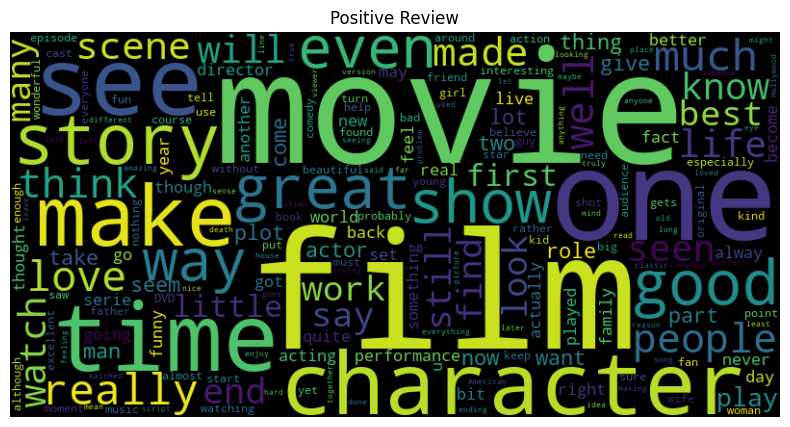

In [17]:
positive = train_df[train_df['sentiment']==1]['Cleaned_sentence'].tolist()
generate_wordcloud(positive,'Positive Review')

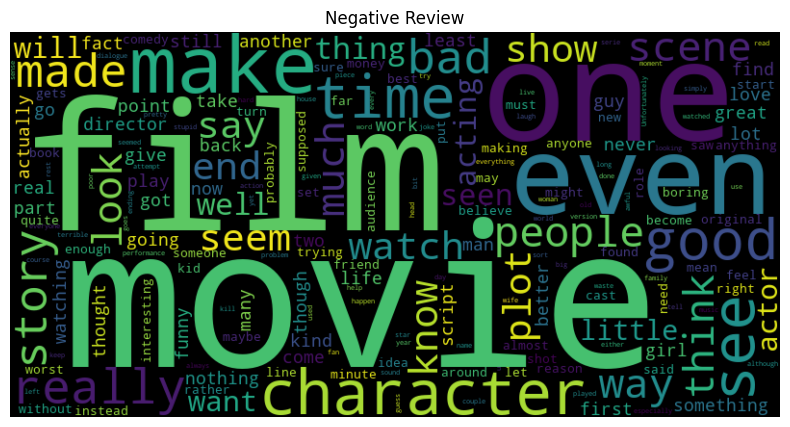

In [18]:
negative = train_df[train_df['sentiment']==0]['Cleaned_sentence'].tolist()
generate_wordcloud(negative,'Negative Review')

In [19]:
# Training data
#Reviews = "[CLS] " +train_df['Cleaned_sentence'] + "[SEP]"
Reviews = train_df['Cleaned_sentence']
Target = train_df['sentiment']

# Test data
#test_reviews = "[CLS] " +test_df['Cleaned_sentence'] + "[SEP]"
test_reviews = test_df['Cleaned_sentence']
test_targets = test_df['sentiment']

In [20]:
x_val, x_test, y_val, y_test = train_test_split(test_reviews,
													test_targets,
													test_size=0.5, 
													stratify = test_targets)


In [22]:
#Tokenize and encode the data using the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [23]:
max_len= 128
# Tokenize and encode the sentences
X_train_encoded = tokenizer.batch_encode_plus(Reviews.tolist(),
											padding=True, 
											truncation=True,
											max_length = max_len,
											return_tensors='tf')

X_val_encoded = tokenizer.batch_encode_plus(x_val.tolist(), 
											padding=True, 
											truncation=True,
											max_length = max_len,
											return_tensors='tf')

X_test_encoded = tokenizer.batch_encode_plus(x_test.tolist(), 
											padding=True, 
											truncation=True,
											max_length = max_len,
											return_tensors='tf')

In [24]:
X_train_encoded

{'input_ids': <tf.Tensor: shape=(25000, 128), dtype=int32, numpy=
array([[  101,  2551,  2007, ...,     0,     0,     0],
       [  101,  2092,  7913, ...,  1010,  1045,   102],
       [  101, 15068,  2818, ...,  2021,  2017,   102],
       ...,
       [  101,  2197,  2281, ...,  2083,  1037,   102],
       [  101,  2307,  3185, ...,  7167,  1997,   102],
       [  101, 22454,  2258, ..., 10684,  2116,   102]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(25000, 128), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(25000, 128), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype

In [25]:
k = 0
print('Training Comments -->>',Reviews[k])
print('\nInput Ids -->>\n',X_train_encoded['input_ids'][k])
print('\nDecoded Ids -->>\n',tokenizer.decode(X_train_encoded['input_ids'][k]))
print('\nAttention Mask -->>\n',X_train_encoded['attention_mask'][k])
print('\nLabels -->>',Target[k])

Training Comments -->> Working with one of the best Shakespeare sources, this film manages to be creditable to it's source, whilst still appealing to a wider audienceBranagh steals the film from under Fishburne's nose, and there's a talented cast on good form

Input Ids -->>
 tf.Tensor(
[  101  2551  2007  2028  1997  1996  2190  8101  4216  1010  2023  2143
  9020  2000  2022  4923  3085  2000  2009  1005  1055  3120  1010  5819
  2145 16004  2000  1037  7289  4378 10024  2532  5603 15539  1996  2143
  2013  2104  3869  8022  2063  1005  1055  4451  1010  1998  2045  1005
  1055  1037 10904  3459  2006  2204  2433   102     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0 

In [26]:
# Intialize the model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
# Compile the model with an appropriate optimizer, loss function, and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [28]:
# Step 5: Train the model
history = model.fit(
	[X_train_encoded['input_ids'], X_train_encoded['token_type_ids'], X_train_encoded['attention_mask']],
	Target,
	validation_data=(
	[X_val_encoded['input_ids'], X_val_encoded['token_type_ids'], X_val_encoded['attention_mask']],y_val),
	batch_size=32,
	epochs=3
)

Epoch 1/3
782/782 [==============================] - 7597s 10s/step - loss: 0.3423 - accuracy: 0.8454 - val_loss: 0.2698 - val_accuracy: 0.8866
Epoch 2/3
151/782 [====>.........................] - ETA: 1:24:42 - loss: 0.1982 - accuracy: 0.9249

KeyboardInterrupt: 